## 회고

#### Point 1) CutMix의 이론적(?) 배경에 대한 개인적인 생각
- 논문에서 말하기로는 CutMix가 메인이미지에서 특정 부분을 잘라내고 다른 이미지로 채움으로서 메인 이미지에서는 좀 덜 discriminative 한 부분에도 CNN이 주의하게끔 도와주고, 또 patch로 붙여진 이미지 역시 그 공간을 버리지 않고 그 이미지 라벨대로 조금이나마 학습한다고 얘기한다.
- 물론 논문에서 실험 결과를 통해 그러한 Augmentation 방법이 도움이 된다고 증명해놓긴 했지만, '진짜로 도움이 될까?' 싶긴 하다.
- 내 생각에 딥러닝 Computer Vision은 약간 근본에 깔린 논리로서 '기계가 사람처럼 보고 이해할 수 있도록 하는 기술'이라고 생각하는데, 사실 사람의 입장에서 보면 그렇게 이것저것 patch로서 갖다 붙인 이미지는 실제로 어떠한 이미지인지 구별하기 더 힘들어지기 때문이다.
- 하나의 예를 들면 어쩌다가 운 나쁘게 가장 클래스 구분에 **가장 도움이 되는** 부분이 잘려나가고 거기에 또 역시 클래스 구분에 **가장 도움이 안되는** 부분이 붙여진 게 계속 학습된다면 이게 과연 효과적인 Augmentation이 될까하는 생각이다.(물론 나보다 더 뛰어난 분들이 '도움이 된다'라고 실험 및 주장을 했으니, 컴퓨터는 그러려니 하고 일단은 생각하려 한다.)

#### Point 2) `repeat()`, `shuffle()`, `batch()`의 순서
- 이번 포인트와 관련한 이슈는 아이펠 노드에 적혀 있는 것과 다르게 나만의 augmentation 적용 함수를 만들다가 생각하게 된 이슈이다.
- 아이펠 노드에서는 `tf.data.Dataset`을 pipeline화 시킬 때 `ds_train.batch(16).repeat().shuffle(200).prefetch()`과 같은 순서로 데이터셋을 만드는데, 이 부분이 데이터를 섞어서 학습에 도움을 주고 있는지 의문이 들었다.
- 결과적으로 나는 저것이 효과적인 데이터셋 생성 방법이 아니라고 결론을 내렸고, 내가 취한 방식은 `ds_train.shuffle().repeat().batch(64).prefetch()`이다.
- 그럼 노드와 나의 차이는 무엇일까?
  - 노드의 데이터셋을 해석하자면, '차례대로 있는 데이터들을 먼저 16개씩 순서대로 묶고, 그 묶음들을 있는 그대로의 순서대로 무한대로 늘려. 그런데 앞에서 부터 200개 배치씩 buffer에 넣은 다음 섞어서 한 배치씩 내보내고 내보낼 때마다 버퍼 내 순서는 다시 섞어(여기서 섞이고 맨 처음에 오는 게 다음에 내보내짐). 그리고 내보낸 자리는 201번째부터 차례대로 집어넣어'이다.
  - 나의 데이터셋을 해석하자면, '먼저 순서 없어지게 다 섞어놔. 그리고 같은 데이터셋을 무한대로 늘릴건데 얘네도 다 전체적으로 섞으면서 갖다붙여. 그리고 그렇게 나온 순서들을 64개씩 묶어서 한 배치씩 내보내'이다.
- 내가 생각하는 노드 코드의 문제점은 특히 CutMix와 Mixup의 경우 한 배치 내에서만 섞일 수가 있는데 노드 코드대로 했을 때는 섞일 수 있는 파트너들이 한정적이란 것이다. 즉, 비슷한 조합들이 계속 반복되는 것이고, 이는 augmentation을 했음에도 overfitting의 요소가 될 수 있는 것이다.
- 결론적으로, 좀 더 강한 randomness를 주고, 모델의 generalisation을 위한다면 `shuffle -> repeat -> batch`의 순서가 맞지 않나 라는 것이 나의 의견이다.


#### Point 3) 진짜 Augmentation의 효과를 보기 위한 ResNet50 파라미터 초기화
- 처음에 겪었던 문제는 아무리 훈련해도 validation accuracy가 오르질 않는 것이었다. 그리고 그와 반대되게 training accuracy는 굉장히 쉽고 빠르게 올라갔다.(약 5에포크만에 95%이상을 찍었다.)
- 이는 '배치 사이즈 문제인가?'싶기도 했지만, 배치 사이즈가 `32`, `64`, `128` 정도 되는 상황에서 accuracy가 0.007 같이 나오는 건 배치 사이즈 문제는 아닌 것 같았고, 종합적으로 판단했을 때 ResNet50 모델을 가져올 때 Dense Layer 부분만 training하는 것으로 가져왔기 때문이라 판단했다.
- Conv 블록의 파라미터들은 `imagenet` 파라미터 설정을 통해 해당 데이터로 훈련된 모델을 가져왔는데, 생각해보니 그 때문에 훈련 폭이 제일 상단의 Dense 층으로만 한정된 것이고, 거기서는 아무리 노력해도 unseen data를 잘 맞출 수 있게 generalise 된 모델을 훈련시킬 수 없는 것 같았다.
- 그래서 그냥 ResNet50 모델 자체를 초기화해서 가져 왔고, 이를 통해 이 경우 pre-trained 모델보다 더 generalise가 잘되는 모델로 훈련될 거라는 생각이 들었는데, 내 생각은 틀렸었다.
- 결론적으로 밑의 시각화된 그래프를 보면 `imagenet` 파라미터를 사용한 모델이 훨씬 더 효율적으로 이번 데이터셋에 잘 훈련되고 테스트셋 예측도 좋았다.
- 이는 어쩌면 `end-to-end` 훈련 모델의 경우 100 에포크가 다소 적은 훈련 수였을 수도 있고, `iamagenet` 데이터가 아무래도 식물 같은 객체의 특징을 이미 잘 담고 있어서 일 수도 있을 것 같다.

#### Point 4) 왜 Data Augmentation이 더 안 좋게 작용했을까?
- 이번 프로젝트에서 무엇보다 제일 중요하게 고민한 부분은 CutMix나 Mixup의 Augmentation 효과가 기본 Augmentation 혹은 아예 보정이 없는 원본 데이터셋보다 **왜 더 안 좋게 작용**했냐는 것이다(테스트셋 예측 및 전반적인 훈련 과정을 봤을 때).
- 일단 제일 의심할 수 있는 부분은 데이터 자체에 대한 관점이다.
  - 이번 oxford flower102 데이터는 102개 클래스를 가졌고, 약 1,000개의 train set, 약 6,000개의 test 셋을 가졌다.
  - 사실 난 이렇게 훈련 데이터가 적고 테스트할 게 훨씬 많은 게 Data Augmentation 효과를 제대로 확인할 수 있겠다라고 생각했는데, 오히려 그 반대였다.
  - 제일 결과가 좋은 `imagenet` pre-trained 모델로 학습한 경우로 볼 때 test set에 대한 accuracy는 `원본 -> 73.35%`, `기본 적용 -> 78.26%`, `기본 + CutMix -> 65.00%`, `기본 + Mixup -> 48.84%`인데, 1,000개 정도의 데이터로 100 epoch나 훈련했으면 _'원본 데이터로 훈련한 모델은 오히려 overfitting이 나고 다른 모델들이 훨씬 큰 폭의 높은 예측률을 보여주지 않을까?'_ 했던 나의 예측이 빗나간 것이다.
  - 이에 대한 하나의 가능성은 은근 6,000개의 test 데이터들이 원본 train 셋과 비슷하게 생긴 것이다...(약간 어거지 같지만...)
- 위와 연관되어 고민해봐야 할 부분은 CutMix와 Mixup의 효과들이다.
  - 사실 이번 프로젝트에서 의도치 않은 실수들로 노트북을 몇 번이나 다시 처음부터 실행했어야 했는데, 단 한번 도 CutMix와 Mixup이 제대로 효과를 낸다고 여겨진 적이 없다.
  - 특히 Mixup의 경우 빈번히(한 5번 정도 노트북을 실행해봤다...) 저 정도 수치의 아주 낮은 예측률을 보여줬는데, 내가 생각하기에 Mixup의 모델 generalisation 효과가 그다지 좋지 않다고 느껴졌다.
  - 꽃이란 것 자체가 뭔가 섞으면 더 애매해지는 걸까? 여튼, 다른 데이터셋을 통해 Data Augmentation 효과를 눈여겨 보자던 나의 계획은 기대치 않은 방향으로 끝맺음지었다.


## 프로젝트: CutMix 또는 Mixup 비교실험 하기
---

#### 배경
- CutMix와 Mixup Augmentation 기법에 대해 이해한다.
- 둘을 Tensorflow 함수로 구현할 줄 안다.
- 둘 중 한 방법을 선택해서 아래의 경우의 수에 대한 훈련 방법들을 비교 분석한다.
  - Augmentation 실시 안 함
  - Augmentation 기본(random_flip, random_brightness)
  - Augmentation 기본 + CutMix
  - Augmentation 기본 + Mixup 

### 1) 라이브러리 버전 확인
---

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


In [2]:
# GPU 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2) 데이터셋 만들기
---
- 꽃을 좋아한다... 꽃 데이터를 사용해보자.
- 모델은 ResNet50을 사용할 예정이니, 은근 파라미터 수가 있는 만큼(약 2,300만 개) 너무 작은 데이터셋은 쉽게 overfitting이 일어날 것 같아서 약 8,000개의 데이터를 갖고 있는 `oxford_flowers102` 데이터셋을 사용하도록 하겠다.
- 참고로 102개의 클래스 라벨을 갖고 있고, train 셋에 1,020장, val 셋에 1,020장, test 셋에 6,149장이 있단다.
- 비교적 작은 수의 데이터셋에 많은 클래스를 갖고 있어서 train, val 셋에는 클래스당 최소 10개씩은 들어가게 조정해놓았다고 하고, test셋에는 최소 20장씩은 들어가게 해놓았단다.
- 위와 같은 이유 때문에 섣부르게 train, test, val을 합치거나 섞는 것은 어려울 것 같고, Data Augmentation의 효과도 봐볼겸 기존에 세팅된 것처럼 약 1,000장의 train 셋을 이용해서 약 6,100장의 이미지를 맞추는 실험을 해보도록 하겠다.

In [3]:
(ds_test, ds_train, ds_val), ds_info = tfds.load('oxford_flowers102',
                                      split=['test', 'train', 'validation'],
                                      shuffle_files=True,
                                      with_info=True,
                                      as_supervised=True)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='oxford_flowers102',
    version=2.1.1,
    description='The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly occurring
in the United Kingdom. Each class consists of between 40 and 258 images. The images have
large scale, pose and light variations. In addition, there are categories that have large
variations within the category and several very similar categories.

The dataset is divided into a training set, a validation set and a test set.
The training set and validation set each consist of 10 images per class (totalling 1020 images each).
The test set consists of the remaining 6149 images (minimum 20 per class).',
    homepage='https://www.robots.ox.ac.uk/~vgg/data/flowers/102/',
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=102),
    }),
    total_num_examples=8

In [5]:
# 데이터셋 개수 확인
print(f"train : {tf.data.experimental.cardinality(ds_train)}")
print(f"test  : {tf.data.experimental.cardinality(ds_test)}")
print(f"val   : {tf.data.experimental.cardinality(ds_val)}")

# 라벨 수 확인
print(f"label : {ds_info.features['label']}")

train : 1020
test  : 6149
val   : 1020
label : ClassLabel(shape=(), dtype=tf.int64, num_classes=102)


In [6]:
# 이미지 크기 및 라벨 종류 확인
for img, label in ds_train.take(1):
    break

print(f"image shape : {img.shape}")
print(f"label looks like : {label}, and shape is {label.shape}")

image shape : (500, 667, 3)
label looks like : 72, and shape is ()


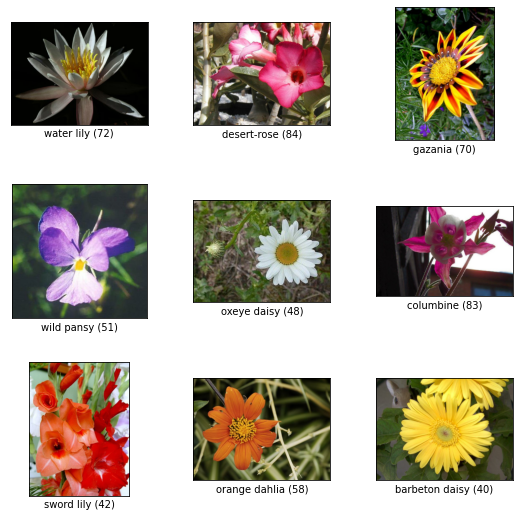

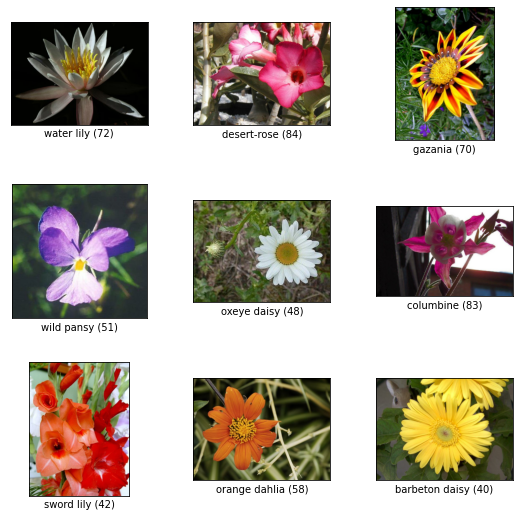

In [7]:
# 이미지 예시 확인
tfds.show_examples(ds_train, ds_info)

### 3) Augmentation 함수 만들기 및 파이프라인에 적용
---

##### 기본 버전(flip_left_right, brightness)
- 색깔도 바꿔볼까 했지만, 꽃은 색깔과 라벨의 연관성이 매우 중요하기 때문에 넣지 않았다.

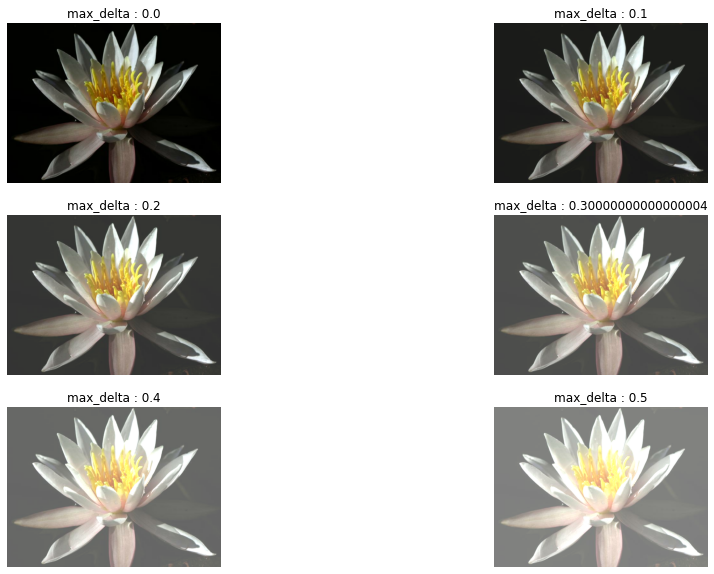

In [8]:
# random_brightness() 함수의 max_delta는 어느 정도까지가 괜찮은지 확인
# random성을 적용하지 않은 adjust_brightness를 통해 적절한 delta 값을 찾아보자.
plt.figure(figsize=(16, 10))
idx = 1
for max_delta in np.arange(0, 0.6, 0.1):
    img_normalised = tf.cast(img, tf.float32) / 255.0
    brighted = tf.image.adjust_brightness(img_normalised, delta=max_delta)
    brighted = tf.clip_by_value(brighted, 0, 1)
    plt.subplot(3, 2, idx)
    plt.imshow(brighted)
    plt.title(f"max_delta : {max_delta}")
    plt.axis("off")
    idx += 1
    if idx == 7:
        break

plt.show()

> **note**:
> - delta 값은 0.2 ~ 0.3 사이가 max로서 적당해 보인다.
> - `0.3`으로 세팅해놓자.

In [9]:
# tf.clip_by_value() 의 역할 확인
x = [[[0.0, 1.0, 0.5],
      [0.0, 0.2, 0.4]],
     [[0.0, 0.2, 0.4],
      [0.0, 0.8, 0.9]]]
xx = tf.image.adjust_brightness(x, 0.2)
xx_clipped = tf.clip_by_value(xx, 0, 1)

print(xx)
print("==============")
print(xx_clipped)

tf.Tensor(
[[[0.2 1.2 0.7]
  [0.2 0.4 0.6]]

 [[0.2 0.4 0.6]
  [0.2 1.  1.1]]], shape=(2, 2, 3), dtype=float32)
tf.Tensor(
[[[0.2 1.  0.7]
  [0.2 0.4 0.6]]

 [[0.2 0.4 0.6]
  [0.2 1.  1. ]]], shape=(2, 2, 3), dtype=float32)


> **note**:
> - train, test 데이터셋 전부 다 라벨이 스칼라 값이 아닌 one-hot vector로 바뀌어야 모델에서 오류가 안 난다.
> - 이에 따라 모든 데이터셋에 기본적으로 적용하는 `normalize_and_resize_img` 함수에서 라벨 부분을 one_hot vector로 바꿔주도록 하겠다.

In [10]:
# one_hot vector 만들 때 사용할 global num_classes 객체 생성
num_classes = ds_info.features['label'].num_classes
num_classes

102

In [11]:
# configuration
BATCH_SIZE = 64

In [12]:
# Augmentation 기본
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    label = tf.one_hot(label, num_classes)
    return tf.cast(image, tf.float32) / 255., label # tensorflow는 dtype이 다르면 오류 남

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.clip_by_value(image, 0, 1) # random_brightness 적용 후 값이 0과 1사이 범위를 벗어나지 못하게 함
    return image, label

In [13]:
# 함수 확인
for t_img, t_label in ds_train.take(4):
    break

print(f"Before img shape : {t_img.shape}")
print(f"Before label shape : {t_label.shape}")

t_img, t_label = normalize_and_resize_img(t_img, t_label)

print(f"Modified img shape : {t_img.shape}")
print(f"Modified label shape : {t_label.shape}")

Before img shape : (500, 667, 3)
Before label shape : ()
Modified img shape : (224, 224, 3)
Modified label shape : (102,)


#### CutMix

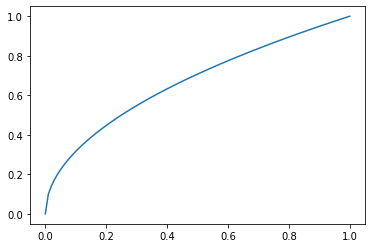

In [14]:
# CutMix에서 클립박스 좌표 생성시 이미지 원래 크기에 곱해주는
# 0 ~ 1 사이 확률값에 sqrt 씌운 이유 확인
# 0 부근의 작은 소수값은 좀 더 exponentially 키워주기 위해 넣어준 것 같다.
x = np.linspace(0, 1, 100)
y = np.sqrt(x)

plt.plot(x, y)
plt.show()

In [15]:
# CutMix
# clip 박스 만드는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :] # 합쳐지는 이미지 윗부분
    bottom = image_a[y_max:image_size_y, :, :] # 합쳐지는 이미지 아랫부분
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

# mix two labels
def mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=num_classes):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0: # 라벨이 스칼라 값이면 one_hot 벡터로 만들어줌
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

# 배치단위로 하는 CutMix
def cutmix(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=224, num_classes=num_classes): # global 변수인 BATCH_SIZE 넣어줌
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, image_b, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### Mixup

In [16]:
# Mixup
# CutMix와 비슷한 구조 혹은 더 간결한 구조임
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

# 배치단위로 하는 Mixup
def mixup(image, label, prob=1.0, batch_size=BATCH_SIZE, img_size=224, num_classes=num_classes):  # global 변수인 BATCH_SIZE 넣어줌
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

#### 종합 Augmentation 실행 함수(CutMix, Mixup 사용 여부 포함)

In [17]:
def preprocess_on_dataset(ds, is_test=False, is_val=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):

    # 전체 다 실행하는 normalize_and_resize(+라벨 one-hot)
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)
    
    if is_test:
        ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE) # test 셋은 한 번의 평가로 필요하기 때문에 repeat, shuffle은 적용하지 않았다.
        return ds
    elif is_val or (not is_test and not is_val and not with_aug):
        ds = ds.shuffle(10000).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE) # val 셋은 계속해서 평가가 필요하기 때문에 배치화와 repeat이 들어감
        return ds

    elif not is_test and not is_val and with_aug:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE) # train일 경우 기본 augmentation은 다 적용
        ds = ds.shuffle(10000).repeat().batch(batch_size) # batch화 먼저 해야 cutmix 및 mixup을 할 수 있음
        if with_cutmix:
            ds = ds.map(cutmix, num_parallel_calls=tf.data.AUTOTUNE)
        elif with_mixup:
            ds = ds.map(mixup, num_parallel_calls=tf.data.AUTOTUNE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
        return ds

#### 데이터 파이프라인 만들기

In [18]:
# 적용
ds_train_raw = preprocess_on_dataset(ds_train, is_test=False, is_val=False, with_aug=False, batch_size=BATCH_SIZE)                           # resize, normalize만
ds_train_norm = preprocess_on_dataset(ds_train, is_test=False, is_val=False, with_aug=True, batch_size=BATCH_SIZE)                           # 기본 Augmentation
ds_train_norm_cutmix = preprocess_on_dataset(ds_train, is_test=False, is_val=False, with_aug=True, batch_size=BATCH_SIZE, with_cutmix=True)  # 기본 Augmentation + cutmix
ds_train_norm_mixup = preprocess_on_dataset(ds_train, is_test=False, is_val=False, with_aug=True, batch_size=BATCH_SIZE, with_mixup=True)    # 기본 Augmentation + mixup
ds_test = preprocess_on_dataset(ds_test, is_test=True, batch_size=BATCH_SIZE)                                                                # 배치 적용
ds_val = preprocess_on_dataset(ds_val, is_val=True, batch_size=BATCH_SIZE)                                                                   # 배치 적용



In [19]:
# 배치 개수 확인(배치 사이즈 아님)
tf.data.experimental.cardinality(ds_train_norm)

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [20]:
# 배치 개수 확인(배치 사이즈 아님)
tf.data.experimental.cardinality(ds_train_norm_cutmix)

<tf.Tensor: shape=(), dtype=int64, numpy=-1>

In [21]:
# shape 확인
ds_train_raw.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))

In [22]:
# shape 확인
ds_train_norm.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))

In [23]:
# shape 확인
ds_train_norm_cutmix.element_spec

(TensorSpec(shape=(64, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(64, 102), dtype=tf.float32, name=None))

In [24]:
# shape 확인
ds_test.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))

In [25]:
# shape 확인
ds_val.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 102), dtype=tf.float32, name=None))

> **note**:
> - `shuffle()`, `repeat()`, `batch()` 각자도 역시 각자만의 기능이 있고, 순서가 중요하다.
> - 간략하게 여태까지 겪었던 오류와 해결 과정을 쓰자면,
> - 1) 세 메소드의 순서가 기대하는 것과 다르게 있었던 것 같은데 이를 좀 변경했다.
> - 2) 훈련 중에 validation 검증을 하려면 val셋도 당연히 batch화 되어야 한다(핵심적으로는 training과 dimension이 같아야 한다.)

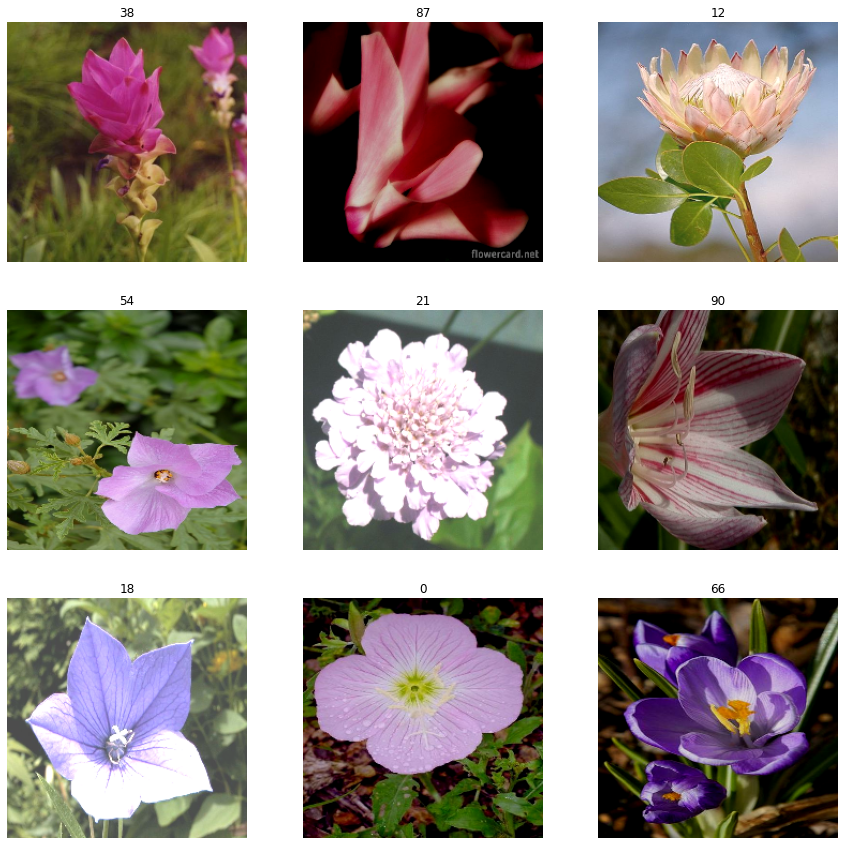

In [26]:
# 데이터 시각화 확인
# 기본 Augmentation만 적용
plt.figure(figsize=(15, 15))

img_batch, label_batch = next(iter(ds_train_norm))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(np.argmax(label_batch[i]))
    plt.imshow(img_batch[i])
    plt.axis("off")
plt.show()

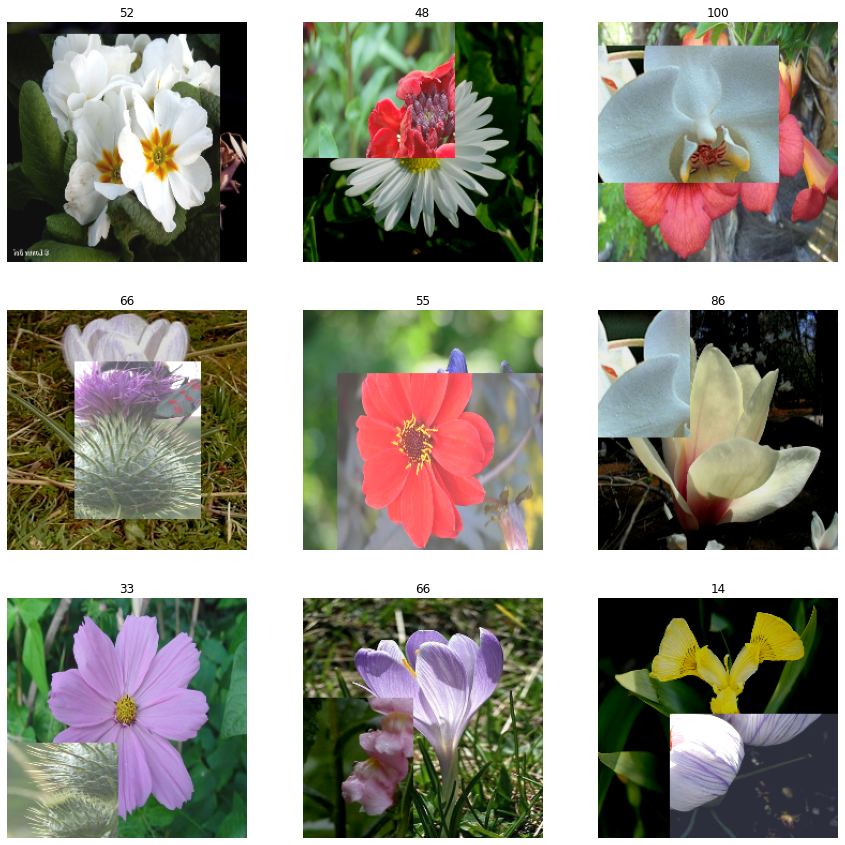

In [27]:
# 데이터 시각화 확인
# 기본 + CutMix 적용
plt.figure(figsize=(15, 15))

img_batch, label_batch = next(iter(ds_train_norm_cutmix))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(np.argmax(label_batch[i]))
    plt.imshow(img_batch[i])
    plt.axis("off")
plt.show()

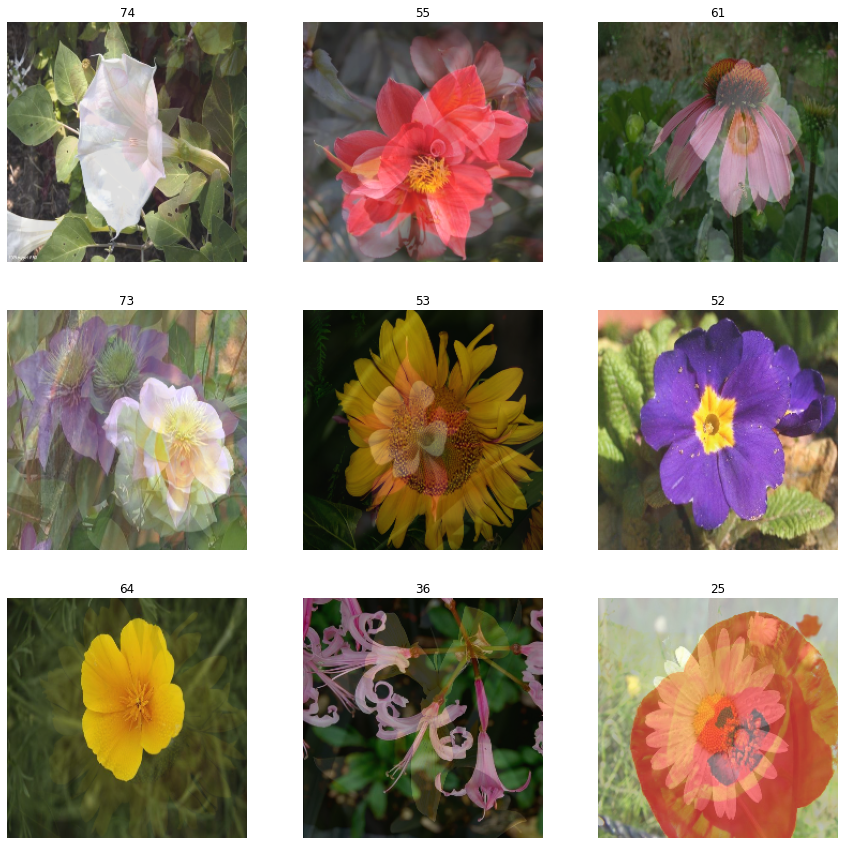

In [28]:
# 데이터 시각화 확인
# 기본 + Mixup 적용
plt.figure(figsize=(15, 15))

img_batch, label_batch = next(iter(ds_train_norm_mixup))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(np.argmax(label_batch[i]))
    plt.imshow(img_batch[i])
    plt.axis("off")
plt.show()

### 4) 모델 만들기
---
- 모델은 TensorFlow에 내장되어 있는 ResNet50을 사용한다.
- 궁금해서 convnet 파라미터도 초기화된 버전에서 훈련시켜보도록 하겠다.

In [29]:
# 모델 만들기
# 일반 데이터셋 훈련 모델
resnet50_none = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights=None,
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='resnet50_none')

# 기본 Augmentation 적용 데이터셋 훈련 모델
resnet50_aug_only = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights=None, 
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='resnet50_aug_only')

# 기본 Augmentation + CutMix 적용 데이터셋 훈련 모델
resnet50_aug_cutmix = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights=None, 
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='resnet50_aug_cutmix')

# 기본 Augmentation + Mixup 적용 데이터셋 훈련 모델
resnet50_aug_mixup = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights=None, 
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='resnet50_aug_mixup')

In [30]:
# 하나만 summary 확인해보기
resnet50_none.summary()

Model: "resnet50_none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 102)               208998    
                                                                 
Total params: 23,796,710
Trainable params: 23,743,590
Non-trainable params: 53,120
_________________________________________________________________


### 5) 모델 컴파일 및 훈련
---
- loss function은 일반적으로 다중클래스 분류에 쓰이는 `sparse_categorical_crossentropy` 대신 `categorical_crossentropy`를 사용한다.(이유는 y_true 값이 one-hot vector이기 때문)

In [31]:
# 모델 모으기
models = [resnet50_none, resnet50_aug_only, resnet50_aug_cutmix, resnet50_aug_mixup]
data_list = [ds_train_raw, ds_train_norm, ds_train_norm_cutmix, ds_train_norm_mixup]

# 컴파일
for model in models:
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
# 체크포인트 설정
# 경로 설정
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
#configuration
EPOCHS = 100

In [33]:
# 훈련
history_list = []
for model, ds in zip(models, data_list):
    checkpoint_path = f'/content/drive/My Drive/Aiffel/GD_04/second/{model.name}'
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)    
    history = model.fit(ds,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=2,
              validation_data=ds_val,
              steps_per_epoch=int(1020//BATCH_SIZE),
              validation_steps=int(1020//BATCH_SIZE),
              callbacks=[model_checkpoint_callback]
              )
    history_list.append(history)
    print("=====================================================")
    print(f"{model.name} training ended ===================")
    print("=====================================================")    

Epoch 1/100
15/15 - 36s - loss: 6.1624 - accuracy: 0.0125 - val_loss: 5.6622 - val_accuracy: 0.0094 - 36s/epoch - 2s/step
Epoch 2/100
15/15 - 14s - loss: 4.8892 - accuracy: 0.0344 - val_loss: 4.9113 - val_accuracy: 0.0104 - 14s/epoch - 937ms/step
Epoch 3/100
15/15 - 15s - loss: 4.3805 - accuracy: 0.0906 - val_loss: 4.8668 - val_accuracy: 0.0135 - 15s/epoch - 1s/step
Epoch 4/100
15/15 - 14s - loss: 3.9465 - accuracy: 0.1146 - val_loss: 7.3741 - val_accuracy: 0.0073 - 14s/epoch - 930ms/step
Epoch 5/100
15/15 - 12s - loss: 3.7170 - accuracy: 0.1573 - val_loss: 11.8956 - val_accuracy: 0.0135 - 12s/epoch - 792ms/step
Epoch 6/100
15/15 - 13s - loss: 3.4621 - accuracy: 0.1667 - val_loss: 26.6921 - val_accuracy: 0.0104 - 13s/epoch - 858ms/step
Epoch 7/100
15/15 - 12s - loss: 3.2882 - accuracy: 0.1917 - val_loss: 22.2525 - val_accuracy: 0.0073 - 12s/epoch - 802ms/step
Epoch 8/100
15/15 - 12s - loss: 2.9956 - accuracy: 0.2500 - val_loss: 6.7115 - val_accuracy: 0.0115 - 12s/epoch - 815ms/step
Epo

#### pre-trained 모델

In [34]:
# 모델 만들기
# 일반 데이터셋 훈련 모델
imagenet_resnet50_none = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights='imagenet',
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='imagenet_resnet50_none')

# 기본 Augmentation 적용 데이터셋 훈련 모델
imagenet_resnet50_aug_only = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights='imagenet', 
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='imagenet_resnet50_aug_only')

# 기본 Augmentation + CutMix 적용 데이터셋 훈련 모델
imagenet_resnet50_aug_cutmix = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights='imagenet', 
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='imagenet_resnet50_aug_cutmix')

# 기본 Augmentation + Mixup 적용 데이터셋 훈련 모델
imagenet_resnet50_aug_mixup = tf.keras.models.Sequential([
                                    tf.keras.applications.resnet.ResNet50(include_top=False, 
                                                                       weights='imagenet', 
                                                                       input_shape=(224,224,3), 
                                                                       pooling='avg'), 
                                    tf.keras.layers.Dense(num_classes, activation='softmax')
                                    ], name='imagenet_resnet50_aug_mixup')

In [35]:
# 하나만 summary 확인해보기
imagenet_resnet50_none.summary()

Model: "imagenet_resnet50_none"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 102)               208998    
                                                                 
Total params: 23,796,710
Trainable params: 23,743,590
Non-trainable params: 53,120
_________________________________________________________________


In [36]:
# 모델 모으기
imagenet_models = [imagenet_resnet50_none, imagenet_resnet50_aug_only, imagenet_resnet50_aug_cutmix, imagenet_resnet50_aug_mixup]

# 컴파일
for model in imagenet_models:
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [37]:
# 훈련
imagenet_history_list = []
for model, ds in zip(imagenet_models, data_list):
    checkpoint_path = f'/content/drive/My Drive/Aiffel/GD_04/second/{model.name}'
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, monitor='val_accuracy', mode='max', save_best_only=True)    
    history = model.fit(ds,
              batch_size=BATCH_SIZE,
              epochs=EPOCHS,
              verbose=2,
              validation_data=ds_val,
              steps_per_epoch=int(1020//BATCH_SIZE),
              validation_steps=int(1020//BATCH_SIZE),
              callbacks=[model_checkpoint_callback]
              )
    imagenet_history_list.append(history)
    print("=====================================================")
    print(f"{model.name} training ended ===================")
    print("=====================================================")    

Epoch 1/100
15/15 - 24s - loss: 3.7212 - accuracy: 0.2427 - val_loss: 8.0001 - val_accuracy: 0.0104 - 24s/epoch - 2s/step
Epoch 2/100
15/15 - 11s - loss: 1.5324 - accuracy: 0.6333 - val_loss: 32.1043 - val_accuracy: 0.0094 - 11s/epoch - 745ms/step
Epoch 3/100
15/15 - 13s - loss: 0.4710 - accuracy: 0.8854 - val_loss: 14.8627 - val_accuracy: 0.0094 - 13s/epoch - 854ms/step
Epoch 4/100
15/15 - 14s - loss: 0.2107 - accuracy: 0.9490 - val_loss: 7.1959 - val_accuracy: 0.0094 - 14s/epoch - 901ms/step
Epoch 5/100
15/15 - 11s - loss: 0.1161 - accuracy: 0.9708 - val_loss: 6.8739 - val_accuracy: 0.0104 - 11s/epoch - 733ms/step
Epoch 6/100
15/15 - 13s - loss: 0.0755 - accuracy: 0.9802 - val_loss: 15.3430 - val_accuracy: 0.0104 - 13s/epoch - 839ms/step
Epoch 7/100
15/15 - 12s - loss: 0.0375 - accuracy: 0.9927 - val_loss: 14.3440 - val_accuracy: 0.0094 - 12s/epoch - 811ms/step
Epoch 8/100
15/15 - 12s - loss: 0.0407 - accuracy: 0.9906 - val_loss: 12.5857 - val_accuracy: 0.0104 - 12s/epoch - 815ms/ste

### 6) 훈련 과정 시각화
---
- 총 100epoch의 훈련을 거친 모델들의 훈련 과정을 시각화해보자.

#### end-to-end 훈련 모델 내 data augmentation 비교

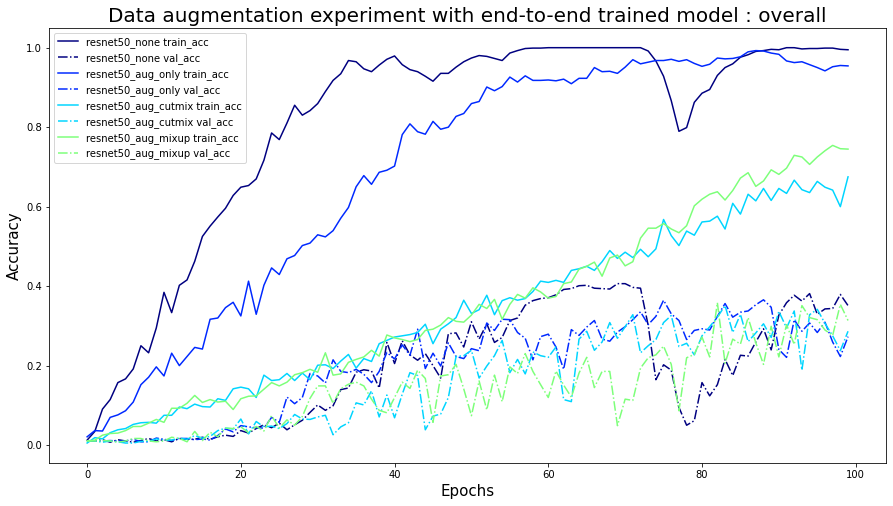

In [38]:
# 시각화
import matplotlib.pylab as pl
colours = pl.cm.jet(np.linspace(0, 0.5, len(models)))

plt.figure(figsize=(15,8))

for idx, model in enumerate(models):
    plt.plot(history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    plt.plot(history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='dashdot', color=colours[idx])

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title("Data augmentation experiment with end-to-end trained model : overall", fontsize=20)
plt.show()

##### train_acc만

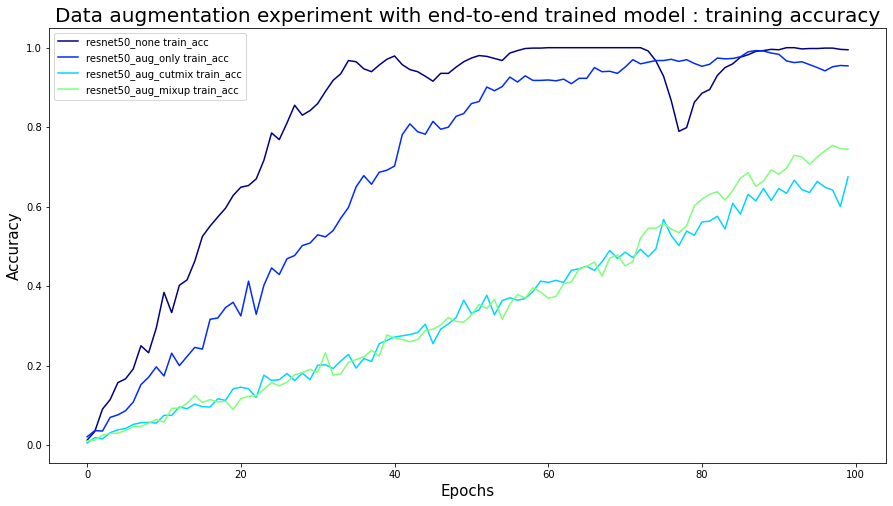

In [39]:
# 시각화
# training accuracy만

plt.figure(figsize=(15,8))

for idx, model in enumerate(models):
    plt.plot(history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    # plt.plot(history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='dashdot', color=colours[idx])

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title("Data augmentation experiment with end-to-end trained model : training accuracy", fontsize=20)
plt.show()

##### val_acc만

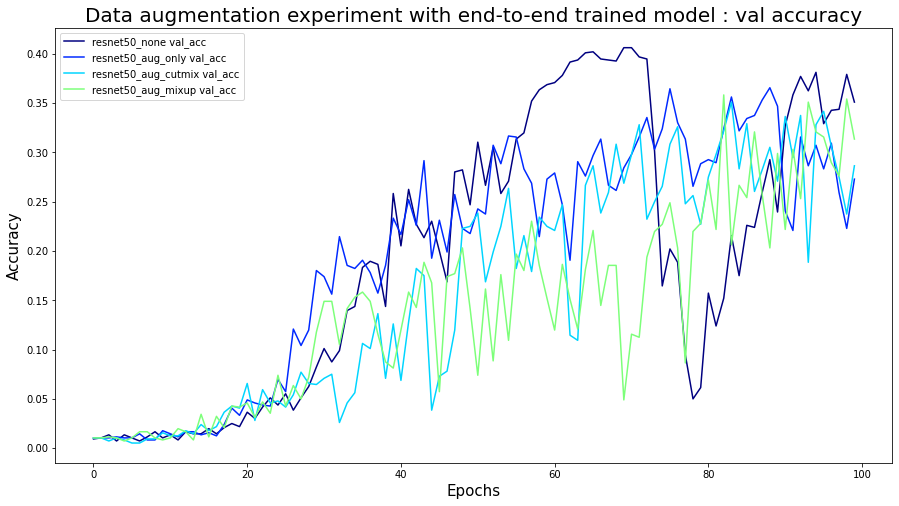

In [40]:
# 시각화
# validation accuracy만

plt.figure(figsize=(15,8))

for idx, model in enumerate(models):
    # plt.plot(history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    plt.plot(history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='solid', color=colours[idx])

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title("Data augmentation experiment with end-to-end trained model : val accuracy", fontsize=20)
plt.show()

#### `imagenet` pre-trained 모델 내 data augmentation 비교
- 아래에 title은 `end-to-end`가 아니라 `pre-trained`로 정정이 필요하다.

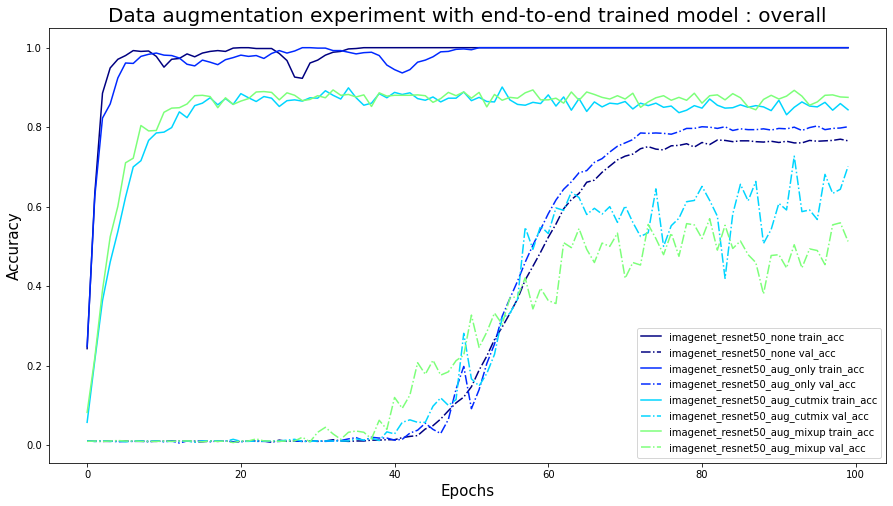

In [41]:
# 시각화
plt.figure(figsize=(15,8))

for idx, model in enumerate(imagenet_models):
    plt.plot(imagenet_history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    plt.plot(imagenet_history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='dashdot', color=colours[idx])

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title("Data augmentation experiment with end-to-end trained model : overall", fontsize=20)
plt.show()

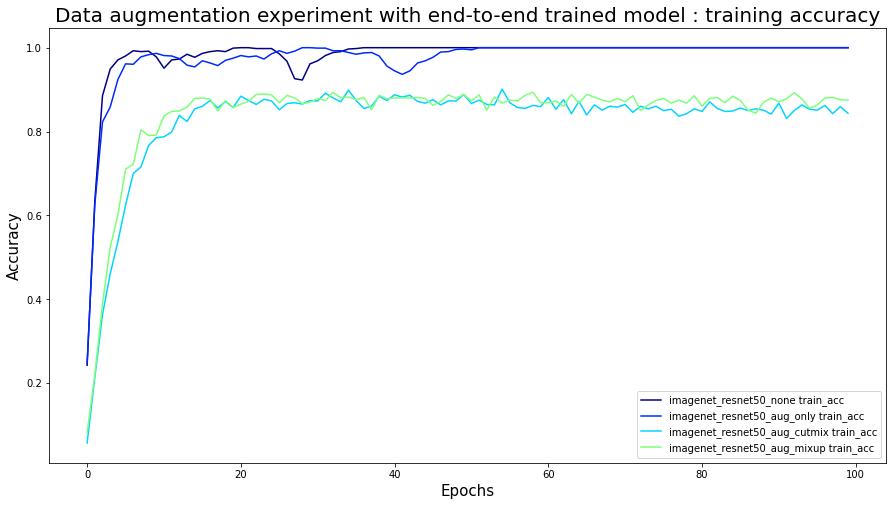

In [42]:
# 시각화
# training accuracy만
plt.figure(figsize=(15,8))

for idx, model in enumerate(imagenet_models):
    plt.plot(imagenet_history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    # plt.plot(imagenet_history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='dashdot', color=colours[idx])

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title("Data augmentation experiment with end-to-end trained model : training accuracy", fontsize=20)
plt.show()

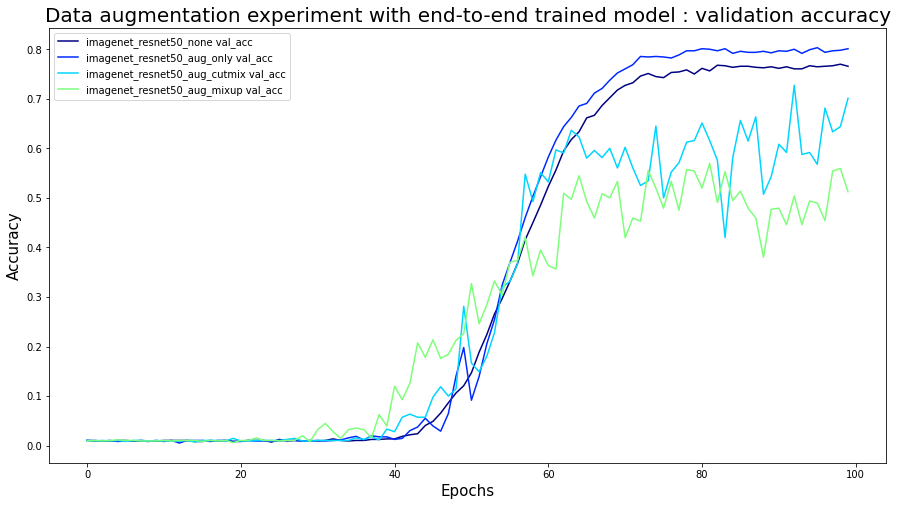

In [43]:
# 시각화
# validation accuracy만
plt.figure(figsize=(15,8))

for idx, model in enumerate(imagenet_models):
    # plt.plot(imagenet_history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    plt.plot(imagenet_history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='solid', color=colours[idx])

plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.title("Data augmentation experiment with end-to-end trained model : validation accuracy", fontsize=20)
plt.show()

#### 같은 data augmentation에 대해서 end-to-end 모델 vs `imagenet` pre-trained 모델

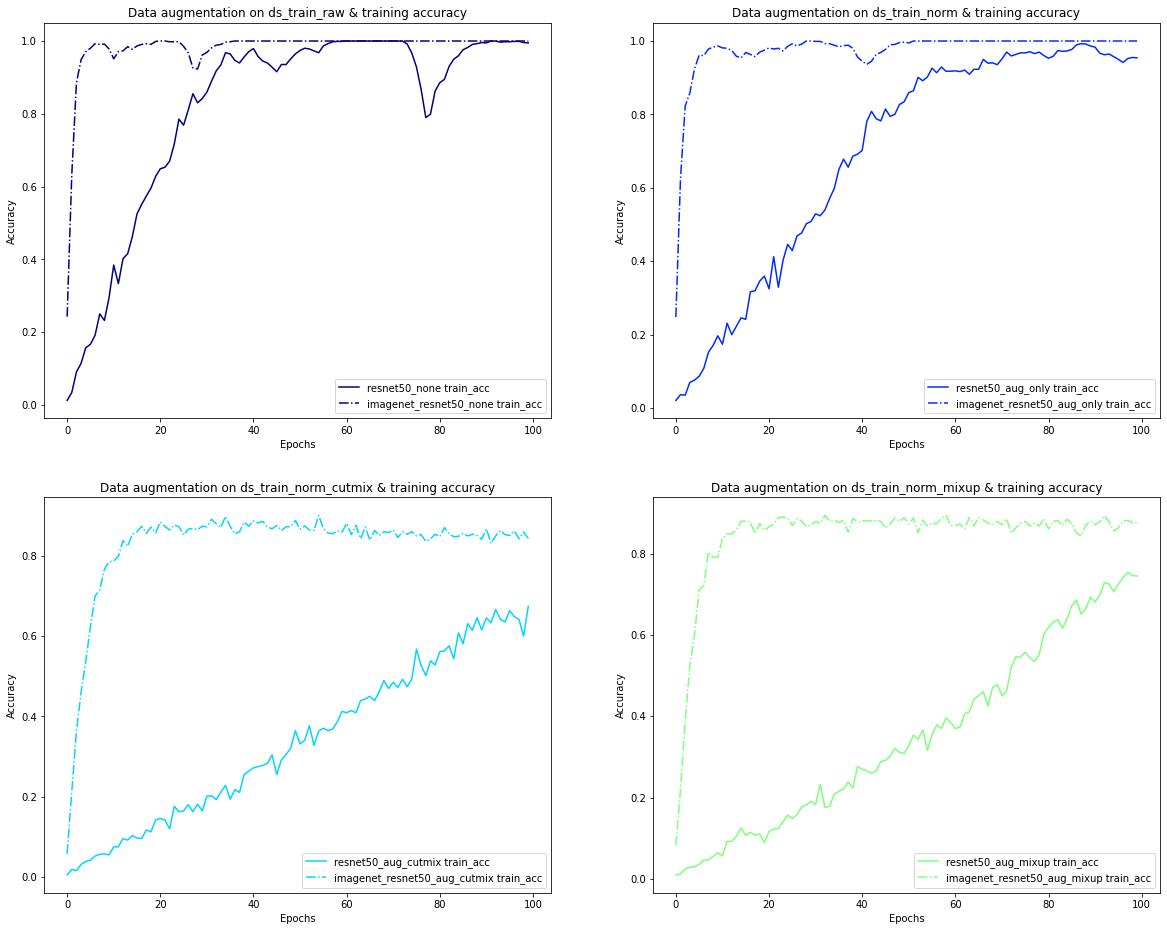

In [44]:
# 시각화
# training accuracy

data_names_list = ['ds_train_raw', 'ds_train_norm', 'ds_train_norm_cutmix', 'ds_train_norm_mixup']
plt.figure(figsize=(20,16))

for idx, (model, imagenet_model, data) in enumerate(zip(models, imagenet_models, data_names_list)):
    plt.subplot(2,2, idx+1)
    plt.plot(history_list[idx].history['accuracy'], label=f'{model.name} train_acc', linestyle='solid', color=colours[idx])
    plt.plot(imagenet_history_list[idx].history['accuracy'], label=f'{imagenet_model.name} train_acc', linestyle='dashdot', color=colours[idx])

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f"Data augmentation on {data} & training accuracy")

plt.show()

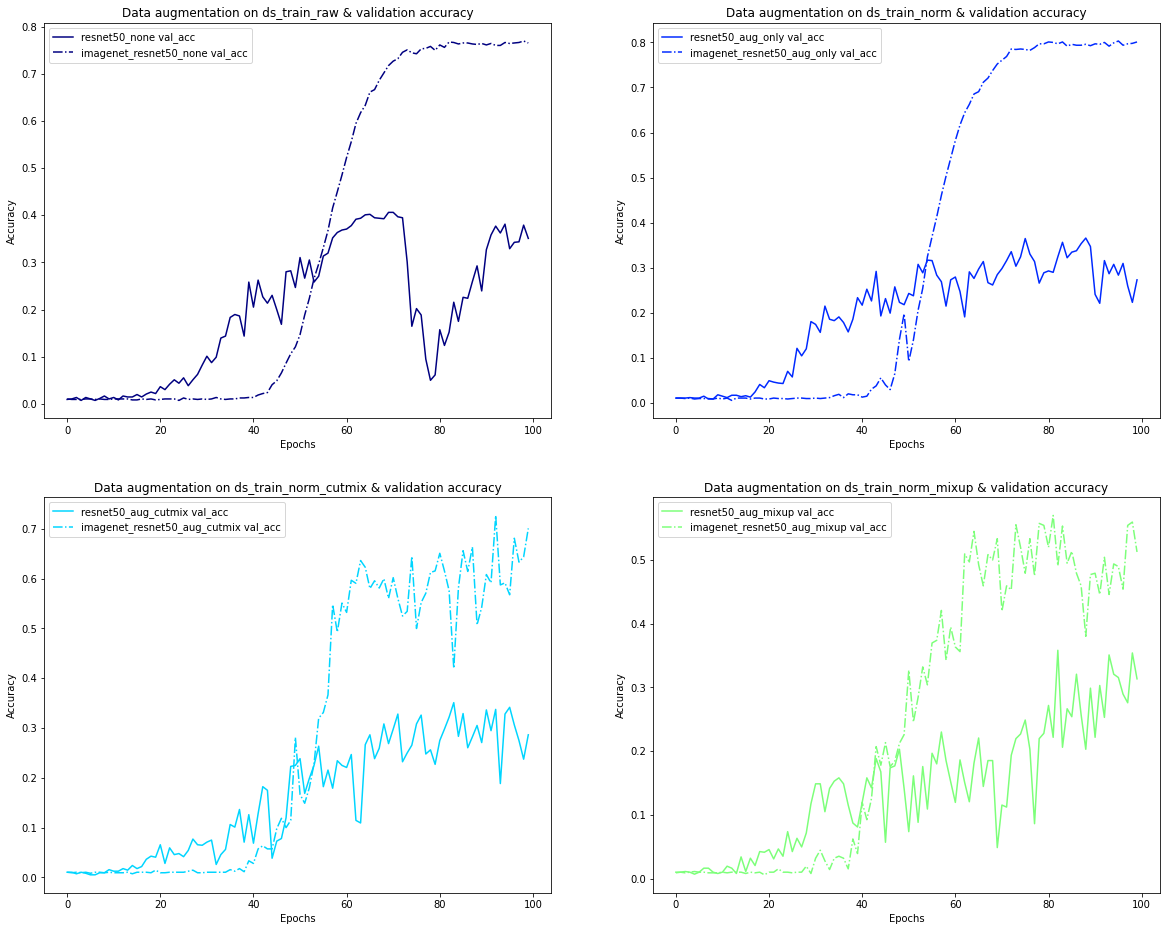

In [45]:
# 시각화
# validation accuracy

plt.figure(figsize=(20,16))

for idx, (model, imagenet_model, data) in enumerate(zip(models, imagenet_models, data_names_list)):
    plt.subplot(2,2, idx+1)
    plt.plot(history_list[idx].history['val_accuracy'], label=f'{model.name} val_acc', linestyle='solid', color=colours[idx])
    plt.plot(imagenet_history_list[idx].history['val_accuracy'], label=f'{imagenet_model.name} val_acc', linestyle='dashdot', color=colours[idx])

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(f"Data augmentation on {data} & validation accuracy")

plt.show()

### 7) Augmentation에 의한 모델 성능 비교(test셋에 예측하기)
---
- 참고로 train 데이터는 약 6,000개이고, train 데이터는 약 1,000개이다.
- 이렇게 적은 데이터를 갖고 훈련한 상황에서 Data Augmentation이 빛을 발할지 궁금하다.

In [46]:
# test 셋에 대한 예측
for model in models:
    loss, acc = model.evaluate(ds_test, verbose=2)
    print("{}, accuracy: {:5.2f}%".format(model.name, 100 * acc))
    print("============================================")

print("")
print("")

# imagenet 모델들
for model in imagenet_models:
    loss, acc = model.evaluate(ds_test, verbose=2)
    print("{}, accuracy: {:5.2f}%".format(model.name, 100 * acc))
    print("============================================")

97/97 - 11s - loss: 5.1163 - accuracy: 0.3207 - 11s/epoch - 117ms/step
resnet50_none, accuracy: 32.07%
97/97 - 11s - loss: 5.8260 - accuracy: 0.2485 - 11s/epoch - 113ms/step
resnet50_aug_only, accuracy: 24.85%
97/97 - 11s - loss: 5.6912 - accuracy: 0.2719 - 11s/epoch - 112ms/step
resnet50_aug_cutmix, accuracy: 27.19%
97/97 - 11s - loss: 3.6720 - accuracy: 0.2843 - 11s/epoch - 112ms/step
resnet50_aug_mixup, accuracy: 28.43%


97/97 - 11s - loss: 1.2132 - accuracy: 0.7335 - 11s/epoch - 112ms/step
imagenet_resnet50_none, accuracy: 73.35%
97/97 - 11s - loss: 1.0279 - accuracy: 0.7826 - 11s/epoch - 111ms/step
imagenet_resnet50_aug_only, accuracy: 78.26%
97/97 - 11s - loss: 1.7064 - accuracy: 0.6500 - 11s/epoch - 112ms/step
imagenet_resnet50_aug_cutmix, accuracy: 65.00%
97/97 - 11s - loss: 2.2760 - accuracy: 0.4884 - 11s/epoch - 112ms/step
imagenet_resnet50_aug_mixup, accuracy: 48.84%
